In [19]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

In [21]:
'''
preparing fake preproc and graphwrap
'''

from graphlearn.processing import PreProcessor
from graphlearn.graph import Wrapper
import graphlearn
class mywrap(Wrapper):
    def clean(self):
        return
    def real_clean(self):
        graphlearn.graph.graph_clean(self._base_graph)

class mypp(PreProcessor):           
    def wrap(self,graph):
        return mywrap(graph,self.vectorizer)
    


In [22]:
%%time
'''
FIRST WE TRAIN A GRAPHSAMPLER
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import graphlearn.utils.interactive as interactive

# setting things up...
training_graphs = gspan_to_eden( '../toolsdata/bursi.pos.gspan' )
training_size=200
training_graphs = itertools.islice(training_graphs,training_size)
sampler=gl.Sampler(radius_list=[0,1], thickness_list=[2],random_state=42447,
                          min_cip_count=2, min_interface_count=2,preprocessor=mypp())
#fitting sampler
sampler.fit(training_graphs)
#sampler.save('tmp/sampler_200.ge')
#loading sampler
#ampler.load('tmp/sampler_200.ge')
interactive.setparameters(sampler)

CPU times: user 2.97 s, sys: 312 ms, total: 3.28 s
Wall time: 6.66 s


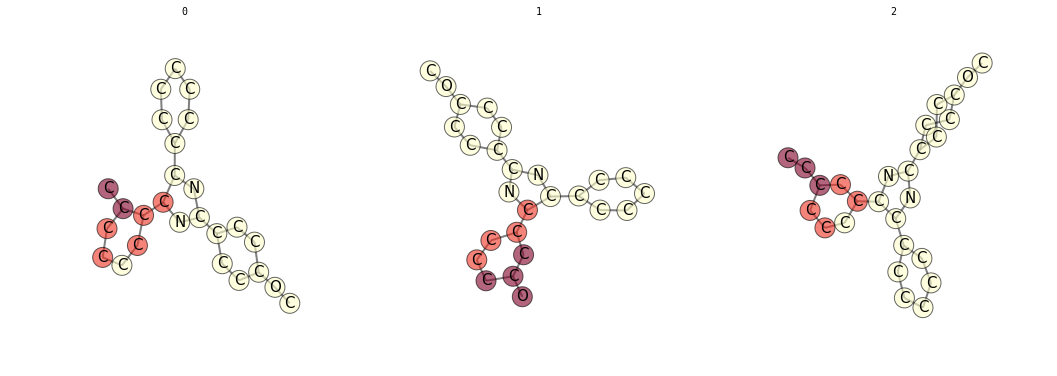

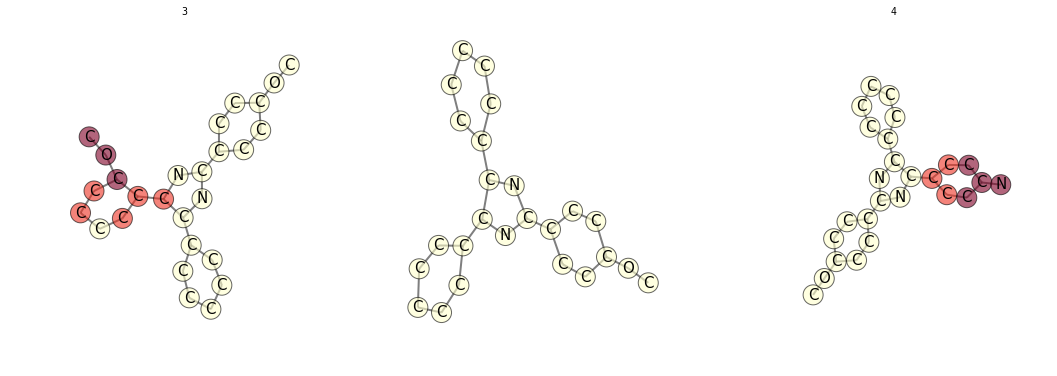

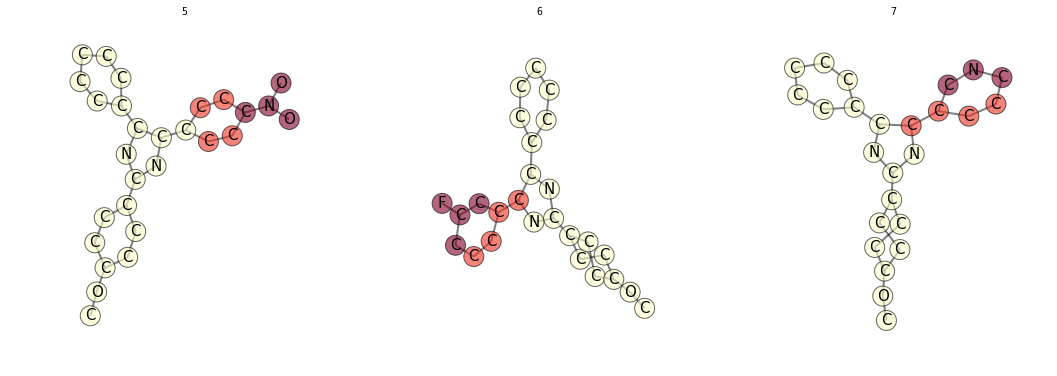

KeyboardInterrupt: 

In [11]:
'''
easy mode
'''


import networkx as nx




from graphlearn.utils import draw
gr = gspan_to_eden( '../toolsdata/bursi.pos.gspan' )
CURRENT = sampler._sample_init(gr.next())

while True:
    # generate 8 graphs
    graphmanz=interactive.easy_get_new_graphs(CURRENT,sampler)
    # put old ine in middle
    g=[grman.base_graph() for grman in graphmanz ]
    g=g[:4]+[CURRENT.base_graph()]+g[4:]
    # draw them 
    draw.graphlearn(g,n_graphs_per_line=3, node_size=400,contract=True,node_border=0.5)
    #pick one
    x=raw_input()
    CURRENT=graphmanz[int(x)]
    CURRENT.real_clean()

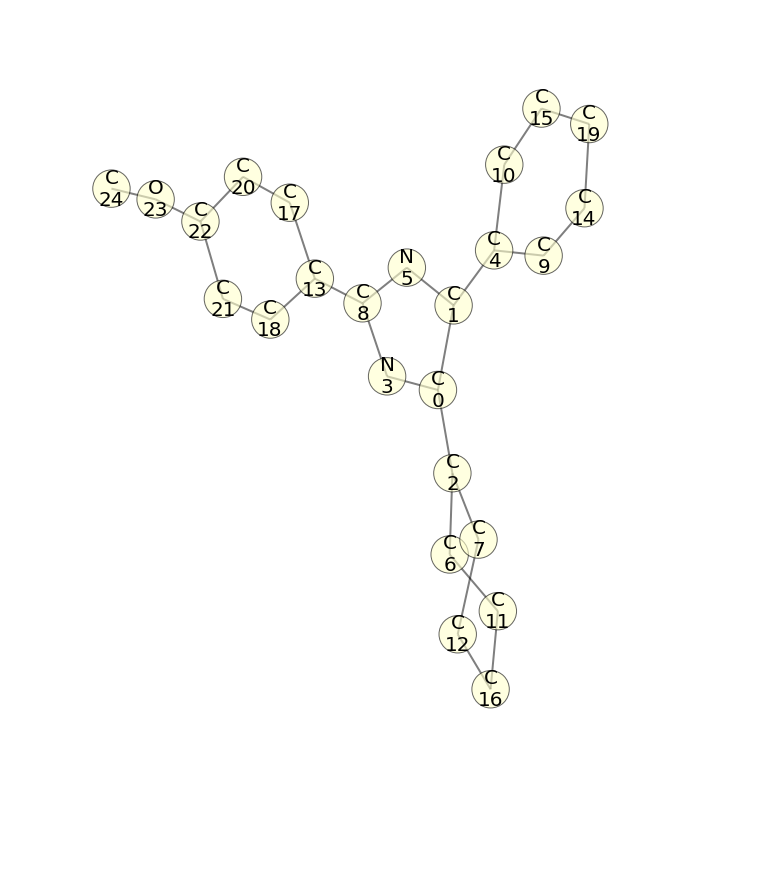

choose a node
16


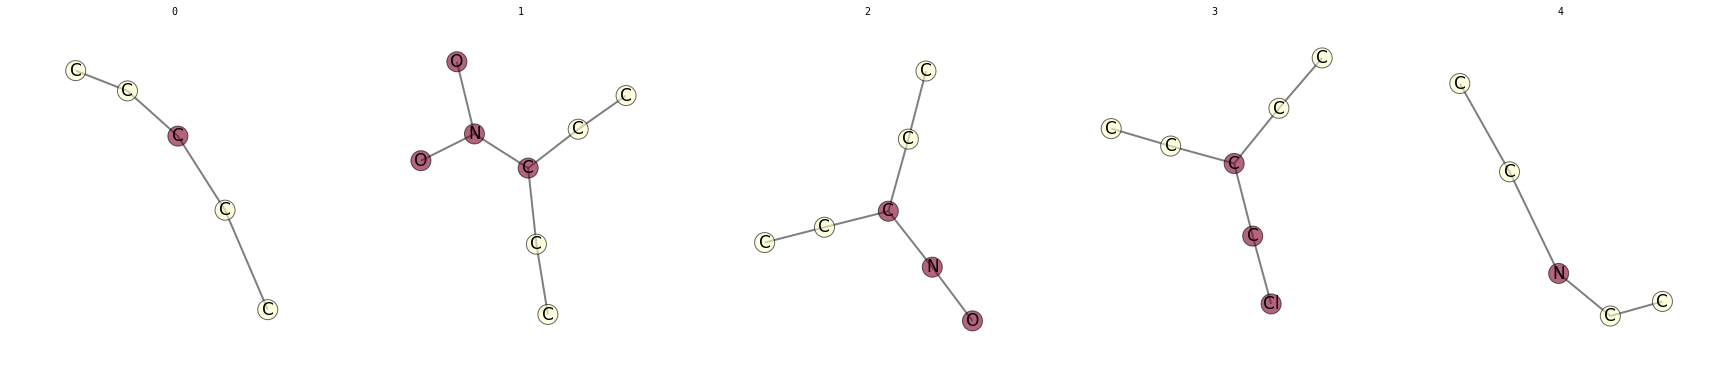

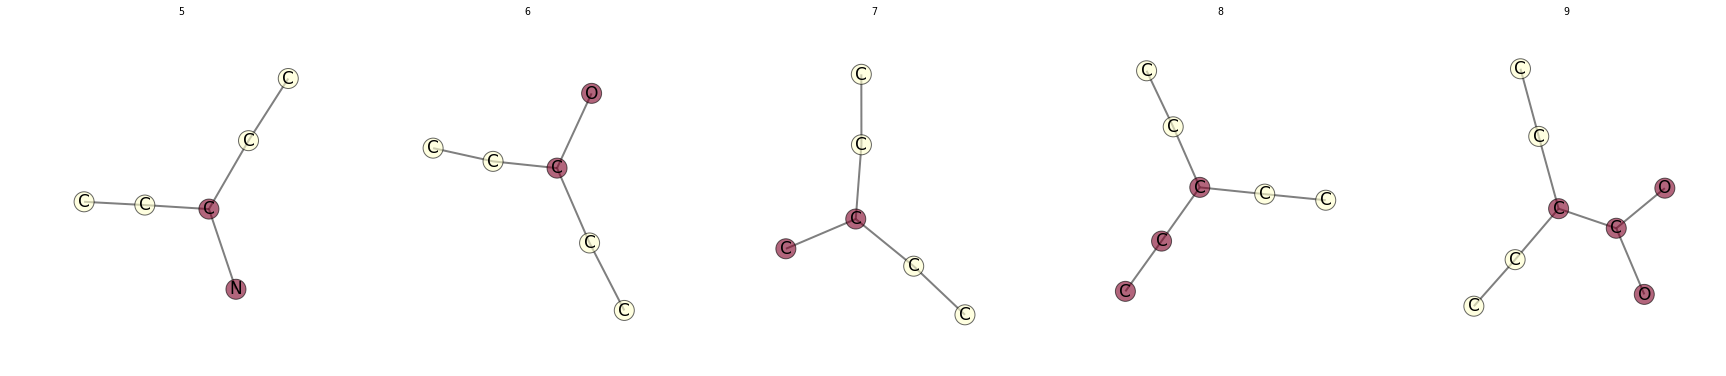

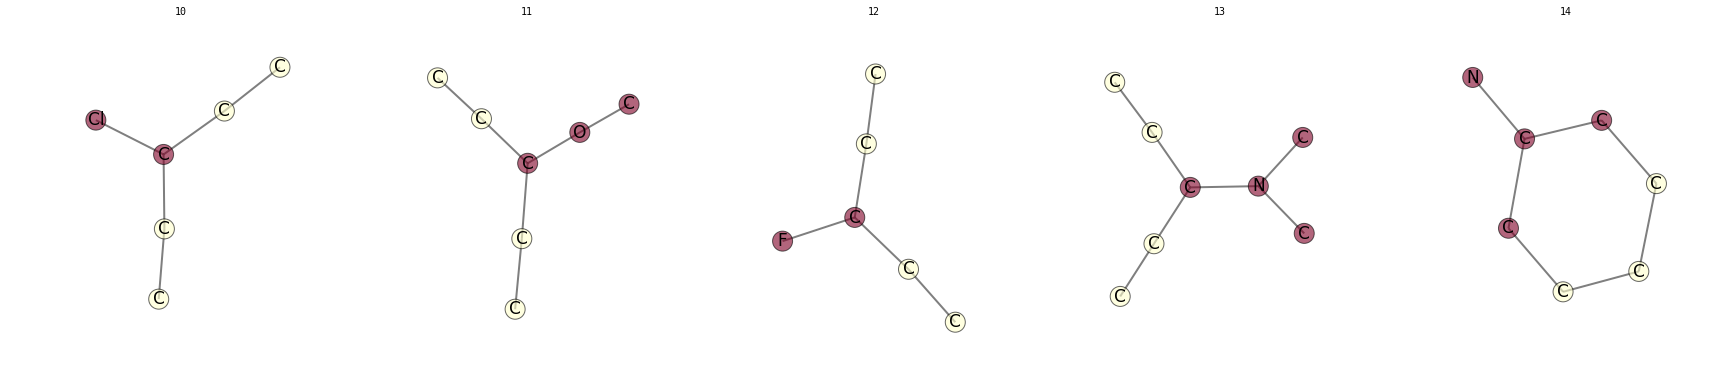

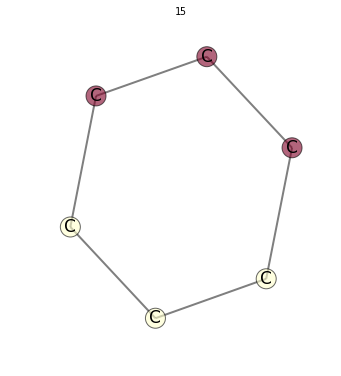

choose a CIP; red nodes will be added
15


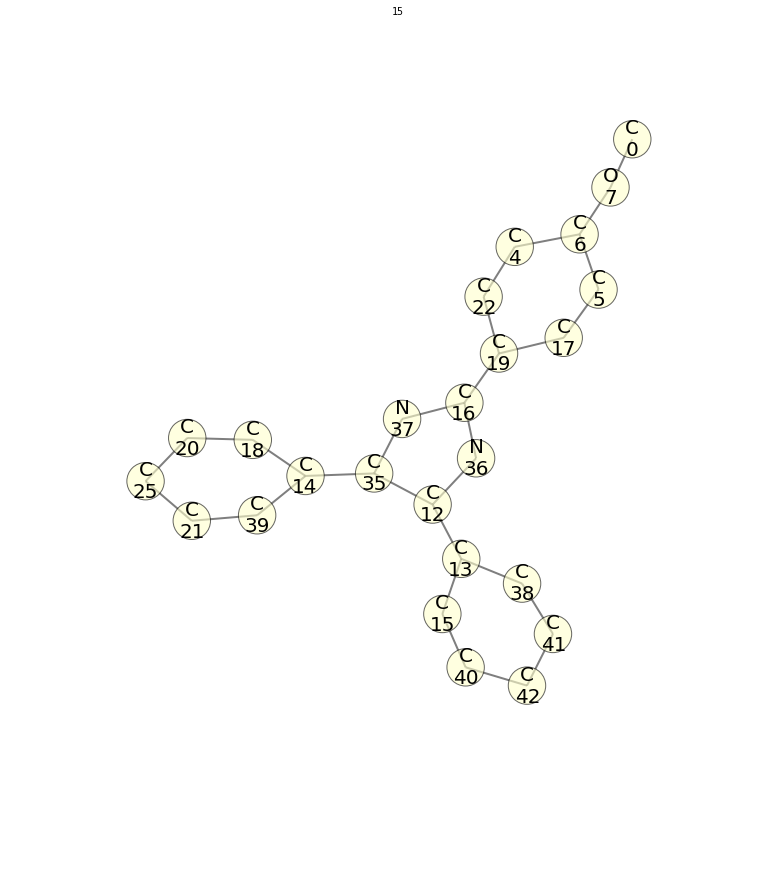

choose a node
123


KeyError: 123

In [27]:
'''
MAX CONTROL MODE
'''

import networkx as nx
from graphlearn.utils import draw


'''
def get_new_graphs(graphwrap):
    res=[]
    graphwrap.clean()
    res= [sampler._propose(graphwrap) for i in range(8)]
    return res
'''

args=interactive.getargz(sampler)
gr = gspan_to_eden( '../toolsdata/bursi.pos.gspan' )
CURRENT = sampler._sample_init(gr.next())
while True: 
    # draw graph and choose node
    draw.graphlearn(CURRENT.base_graph(),secondary_vertex_label='id',size=15,contract=True, node_size=1400,font_size=20,node_border=0.5)
    print "choose a node"
    node_id=int(raw_input())
    
    # draw new cips and choose one
    cips=interactive.get_cips(CURRENT,sampler,node_id,args)
    if len(cips)==0:
        print 'no replacements found,try again'
        continue
    cip_graphs=[ c.graph for c in cips ]
    draw.graphlearn(cip_graphs, node_border=0.5, node_size=400,font_size=17,contract=True,title_key='info')
    print "choose a CIP; red nodes will be added"
    cip_id=int(raw_input())
    
    #replace and clean
    gr=CURRENT.core_substitution( cips[cip_id].orig, cip_graphs[cip_id])
    CURRENT=sampler.preprocessor.re_transform_single(gr)
    CURRENT.real_clean()
    

In [25]:
print cip_graphs[0].

KeyError: 'info'